In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import RNA
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import mlflow

# RNA-FAM libraries
from multimolecule import RnaTokenizer, RnaFmModel

/Users/angelmurillo/Desktop/ML Projects/3UTR_BERT/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Dataset

In [2]:
df = pd.read_excel("/Users/angelmurillo/Desktop/ML Projects/3UTR_BERT/dataset_builder/Huesken_dataset_cleaned.xlsx")
df = df[['siRNA', 'mRNA', 'normalized_inhibition']]
df.head()

,siRNA,mRNA,normalized_inhibition
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262


# Feature Engineering (ViennaRNA)


In [3]:
# I need to convert the DNA sequences to RNA sequences before calculating the MFE 

def dna_to_rna(sequence):
    return sequence.replace('T', 'U')

df['siRNA_rna'] = df['siRNA'].apply(dna_to_rna)
df['mRNA_rna'] = df['mRNA'].apply(dna_to_rna)

#display first few rows with new columns as rna
df.head()

,siRNA,mRNA,normalized_inhibition,siRNA_rna,mRNA_rna
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,CUAAUAUGUUAAUUGAUUUAU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,AAUAUGUUAAUUGAUUUAUAC,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,GAUUUAUACAAUUCCUUUCAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,CAAUUCCUUUCAAUUUUAUCU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,CAGACCAAAAUUAAAUAAGAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...


In [4]:
# Function to calculate MFE
def calculate_mfe(sequence):
    """Calculate minimum free energy of RNA sequence using ViennaRNA"""
    # Calculate MFE (returns tuple of (structure, mfe))
    mfe = RNA.fold(sequence)[1]
    return mfe

# Calculate MFE for both siRNA 
df['siRNA_mfe'] = df['siRNA_rna'].apply(calculate_mfe)

# Display first few rows with new features
print("Dataset with MFE features:")
df.head(-10)

Dataset with MFE features:


,siRNA,mRNA,normalized_inhibition,siRNA_rna,mRNA_rna,siRNA_mfe
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,CUAAUAUGUUAAUUGAUUUAU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,AAUAUGUUAAUUGAUUUAUAC,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,GAUUUAUACAAUUCCUUUCAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,CAAUUCCUUUCAAUUUUAUCU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,CAGACCAAAAUUAAAUAAGAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0
...,...,...,...,...,...,...
2416,CCTTGCATCTGATTTTCAGTA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.637584,CCUUGCAUCUGAUUUUCAGUA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4
2417,ATCTGATTTTCAGTAACAATC,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.403430,AUCUGAUUUUCAGUAACAAUC,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4
2418,TCTGATTTTCAGTAACAATCA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.556301,UCUGAUUUUCAGUAACAAUCA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4
2419,TGATGATGACAAAGACCGAGG,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.542878,UGAUGAUGACAAAGACCGAGG,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,0.0


# Feature Engineering (Dot Bracket Notation)

In [5]:
def calculate_dbn_ratio(sequence):
    """Calculate ratio of paired (brackets) to unpaired (dots) nucleotides in RNA structure
    Returns: ratio of paired nucleotides (number of brackets / sequence length)"""
    
    # Get structure in dot-bracket notation (returns tuple of (structure, mfe))
    structure = RNA.fold(sequence)[0]
    
    # Count brackets (paired nucleotides) and dots (unpaired)
    paired = structure.count('(') + structure.count(')')  # Count both opening and closing brackets
    total_length = len(structure)
    
    # Calculate ratio of paired nucleotides
    ratio = paired / (2 * total_length)  # Divide by 2 since we counted both ( and )
    
    return ratio

# Calculate DBN ratio for both siRNA and mRNA sequences
df['siRNA_dbn_ratio'] = df['siRNA_rna'].apply(calculate_dbn_ratio)


# Display first few rows with new features
print("Dataset with DBN ratio features:")
df.head(-10)

Dataset with DBN ratio features:


,siRNA,mRNA,normalized_inhibition,siRNA_rna,mRNA_rna,siRNA_mfe,siRNA_dbn_ratio
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,CUAAUAUGUUAAUUGAUUUAU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,AAUAUGUUAAUUGAUUUAUAC,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,GAUUUAUACAAUUCCUUUCAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,CAAUUCCUUUCAAUUUUAUCU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,CAGACCAAAAUUAAAUAAGAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000
...,...,...,...,...,...,...,...
2416,CCTTGCATCTGATTTTCAGTA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.637584,CCUUGCAUCUGAUUUUCAGUA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476
2417,ATCTGATTTTCAGTAACAATC,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.403430,AUCUGAUUUUCAGUAACAAUC,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476
2418,TCTGATTTTCAGTAACAATCA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.556301,UCUGAUUUUCAGUAACAAUCA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476
2419,TGATGATGACAAAGACCGAGG,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.542878,UGAUGAUGACAAAGACCGAGG,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,0.0,0.000000


# Feature Engineering (RNA-FAM)

In [6]:
import numpy as np

tokenizer = RnaTokenizer.from_pretrained('multimolecule/rnafm')
rnafm_model = RnaFmModel.from_pretrained('multimolecule/rnafm')

# Initializing a list to store the feature vectors
siRNA_features_list = []

# Function to extract features from each siRNA sequence
def extract_features(sequence):
    input_data = tokenizer(sequence, return_tensors='pt')
    with torch.no_grad():
        output = rnafm_model(**input_data)
    features = output.last_hidden_state.squeeze().mean(dim=0)
    return features.numpy()

# Apply the function to each siRNA and store the features in the list
for sequence in df['siRNA_rna']:
    features = extract_features(sequence)
    siRNA_features_list.append(features)

# Convert the list to a numpy array for later use
siRNA_features_array = np.array(siRNA_features_list)

# Check the dimensions of the extracted features
print(f"Feature array shape: {siRNA_features_array.shape}") #generated an array of 2431 X 640

Some weights of RnaFmModel were not initialized from the model checkpoint at multimolecule/rnafm and are newly initialized: ['rnafm.pooler.dense.bias', 'rnafm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Feature array shape: (2431, 640)


# Feature Engineering (G/C content)

In [7]:
def calculate_gc_content(sequence):
    """Calculate GC content of DNA sequence"""
    gc_count = sequence.count('G') + sequence.count('C')
    total_length = len(sequence)
    gc_content = gc_count / total_length
    return gc_content

# Calculate GC content for both siRNA and mRNA sequences
df['siRNA_gc_content'] = df['siRNA_rna'].apply(calculate_gc_content)
df['mRNA_gc_content'] = df['mRNA_rna'].apply(calculate_gc_content)

# Display first few rows with new features
print("Dataset with GC content features:")
df.head(-10)

Dataset with GC content features:


,siRNA,mRNA,normalized_inhibition,siRNA_rna,mRNA_rna,siRNA_mfe,siRNA_dbn_ratio,siRNA_gc_content,mRNA_gc_content
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,CUAAUAUGUUAAUUGAUUUAU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000,0.142857,0.382766
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,AAUAUGUUAAUUGAUUUAUAC,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000,0.142857,0.382766
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,GAUUUAUACAAUUCCUUUCAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000,0.238095,0.382766
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,CAAUUCCUUUCAAUUUUAUCU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000,0.238095,0.382766
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,CAGACCAAAAUUAAAUAAGAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000,0.238095,0.382766
...,...,...,...,...,...,...,...,...,...
2416,CCTTGCATCTGATTTTCAGTA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.637584,CCUUGCAUCUGAUUUUCAGUA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476,0.380952,0.521750
2417,ATCTGATTTTCAGTAACAATC,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.403430,AUCUGAUUUUCAGUAACAAUC,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476,0.285714,0.521750
2418,TCTGATTTTCAGTAACAATCA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.556301,UCUGAUUUUCAGUAACAAUCA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476,0.285714,0.521750
2419,TGATGATGACAAAGACCGAGG,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.542878,UGAUGAUGACAAAGACCGAGG,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,0.0,0.000000,0.476190,0.521750


# Clean up the dataset & Normalize

In [8]:
df_cleaned= df.drop(columns=['siRNA_rna', 'mRNA_rna'])
df_cleaned.head()

,siRNA,mRNA,normalized_inhibition,siRNA_mfe,siRNA_dbn_ratio,siRNA_gc_content,mRNA_gc_content
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,0.0,0.0,0.142857,0.382766
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,0.0,0.0,0.142857,0.382766
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,0.0,0.0,0.238095,0.382766
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,0.0,0.0,0.238095,0.382766
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,0.0,0.0,0.238095,0.382766


In [9]:
# Only normalize DBN ratio and GC content
df_cleaned['siRNA_dbn_ratio_norm'] = (df['siRNA_dbn_ratio'] - df['siRNA_dbn_ratio'].min()) / (df['siRNA_dbn_ratio'].max() - df['siRNA_dbn_ratio'].min())
df_cleaned['siRNA_gc_content_norm'] = (df['siRNA_gc_content'] - df['siRNA_gc_content'].min()) / (df['siRNA_gc_content'].max() - df['siRNA_gc_content'].min())
df_cleaned['mRNA_gc_content_norm'] = (df['mRNA_gc_content'] - df['mRNA_gc_content'].min()) / (df['mRNA_gc_content'].max() - df['mRNA_gc_content'].min())
df_cleaned.head()

,siRNA,mRNA,normalized_inhibition,siRNA_mfe,siRNA_dbn_ratio,siRNA_gc_content,mRNA_gc_content,siRNA_dbn_ratio_norm,siRNA_gc_content_norm,mRNA_gc_content_norm
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,0.0,0.0,0.142857,0.382766,0.0,0.000000,0.138621
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,0.0,0.0,0.142857,0.382766,0.0,0.000000,0.138621
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,0.0,0.0,0.238095,0.382766,0.0,0.117647,0.138621
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,0.0,0.0,0.238095,0.382766,0.0,0.117647,0.138621
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,0.0,0.0,0.238095,0.382766,0.0,0.117647,0.138621


In [10]:
df_final= df_cleaned.drop(columns=['siRNA_dbn_ratio', 'siRNA_gc_content', 'mRNA_gc_content'])
df_final.head(-10)

,siRNA,mRNA,normalized_inhibition,siRNA_mfe,siRNA_dbn_ratio_norm,siRNA_gc_content_norm,mRNA_gc_content_norm
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,0.0,0.000000,0.000000,0.138621
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,0.0,0.000000,0.000000,0.138621
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,0.0,0.000000,0.117647,0.138621
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,0.0,0.000000,0.117647,0.138621
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,0.0,0.000000,0.117647,0.138621
...,...,...,...,...,...,...,...
2416,CCTTGCATCTGATTTTCAGTA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.637584,-1.4,0.444444,0.294118,0.600680
2417,ATCTGATTTTCAGTAACAATC,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.403430,-1.4,0.444444,0.176471,0.600680
2418,TCTGATTTTCAGTAACAATCA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.556301,-1.4,0.444444,0.176471,0.600680
2419,TGATGATGACAAAGACCGAGG,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.542878,0.0,0.000000,0.411765,0.600680


# Function to create K-mer features

In [11]:
# Function to create k-mers
def create_kmers(seq, k=6):
    """Convert sequence to k-mers"""
    kmers = [seq[i:i+k] for i in range(len(seq) - k + 1)]
    return " ".join(kmers)

# Split the dataset into training, testing, and validation(70/15/15)

In [12]:
# Split data into train, validation, and test (70/15/15)
train_val_df, test_df, train_val_features, test_features = train_test_split(
    df_final, 
    siRNA_features_array,
    test_size=0.15, 
    random_state=42
)

# Second split: divide remaining data into train (70%) and validation (15%)
train_df, validation_df, train_features, val_features = train_test_split(
    train_val_df, 
    train_val_features,
    test_size=0.176, 
    random_state=42
)

# Check dataset lengths
print(f"Train set: {len(train_df)}, Validation set: {len(validation_df)}, Test set: {len(test_df)}")
print(f"Train features: {train_features.shape}, Validation features: {val_features.shape}, Test features: {test_features.shape}")

Train set: 1702, Validation set: 364, Test set: 365
Train features: (1702, 640), Validation features: (364, 640), Test features: (365, 640)


# Model Architecture

In [13]:
# Modified preprocessing function to include RNA-FM embeddings
def preprocess_sequences(sirna_seq, mrna_seq, numerical_features, siRNA_features_array, tokenizer, max_length=512):
    # Process siRNA and mRNA
    sirna_encoded = tokenizer(
        create_kmers(sirna_seq),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    mrna_encoded = tokenizer(
        create_kmers(mrna_seq),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    # Convert numerical features and RNA-FM embeddings to tensors
    numerical_tensor = torch.tensor(numerical_features, dtype=torch.float32)
    rnafm_tensor = torch.tensor(siRNA_features_array, dtype=torch.float32)
    return sirna_encoded, mrna_encoded, numerical_tensor, rnafm_tensor

# Modified DualDNABERT model
class DualDNABERT_2(nn.Module):
    def __init__(self, bert_model_name="zhihan1996/DNA_bert_6", num_numerical_features=4, rnafm_size=640):
        super().__init__()
        # Keep existing BERT initialization
        self.sirna_bert = AutoModel.from_pretrained(bert_model_name)
        self.mrna_bert = AutoModel.from_pretrained(bert_model_name)
        
        # Freeze layers
        for name, param in self.sirna_bert.named_parameters():
            if 'pooler' not in name:
                param.requires_grad = False
        for name, param in self.mrna_bert.named_parameters():
            if 'pooler' not in name:
                param.requires_grad = False
        
        hidden_size = self.sirna_bert.config.hidden_size
        
        # Modified regression head to include RNA-FM embeddings
        self.regression_head = nn.Sequential(
            nn.Linear(hidden_size * 2 + num_numerical_features + rnafm_size, 512),  # Modified input size
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, sirna_inputs, mrna_inputs, numerical_features, siRNA_features_array):
        # Process sequences
        sirna_outputs = self.sirna_bert(**sirna_inputs)[1]
        mrna_outputs = self.mrna_bert(**mrna_inputs)[1]
        
        # Concatenate BERT outputs with numerical features and RNA-FM embeddings
        combined = torch.cat((sirna_outputs, mrna_outputs, numerical_features, siRNA_features_array), dim=1)
        
        # Pass through regression head
        output = self.regression_head(combined)
        return output

# Create the dataset class

In [14]:
class SiRNADataset(Dataset):
    def __init__(self, sirna_seqs, mrna_seqs, numerical_features, siRNA_features_array, labels, tokenizer, max_length=512):
        self.sirna_seqs = sirna_seqs
        self.mrna_seqs = mrna_seqs
        self.numerical_features = numerical_features
        self.siRNA_features_array = siRNA_features_array  
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sirna_encoded, mrna_encoded, numerical_tensor, rnafm_tensor = preprocess_sequences(
            self.sirna_seqs[idx],
            self.mrna_seqs[idx],
            self.numerical_features[idx],
            self.siRNA_features_array[idx],  
            self.tokenizer,
            self.max_length
        )

        return {
            'sirna_inputs': {
                'input_ids': sirna_encoded['input_ids'].flatten(),
                'attention_mask': sirna_encoded['attention_mask'].flatten()
            },
            'mrna_inputs': {
                'input_ids': mrna_encoded['input_ids'].flatten(),
                'attention_mask': mrna_encoded['attention_mask'].flatten()
            },
            'numerical_features': numerical_tensor.flatten(),
            'siRNA_features_array': rnafm_tensor.flatten(),  
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Create DataLoaders and Initialize the model

In [15]:
# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  

# Initialize model with numerical features and RNA-FM size
model = DualDNABERT_2(num_numerical_features=4, rnafm_size=640)  # 4 numerical features, 640 RNA-FM features
model = model.to(device)

# Create datasets
train_dataset = SiRNADataset(
    sirna_seqs=train_df['siRNA'].values,
    mrna_seqs=train_df['mRNA'].values,
    numerical_features=train_df[['siRNA_mfe', 'siRNA_dbn_ratio_norm',
                                'siRNA_gc_content_norm', 'mRNA_gc_content_norm']].values,
    siRNA_features_array=train_features,  # Add RNA-FM embeddings
    labels=train_df['normalized_inhibition'].values,
    tokenizer=tokenizer
)

validation_dataset = SiRNADataset(
    sirna_seqs=validation_df['siRNA'].values,
    mrna_seqs=validation_df['mRNA'].values,
    numerical_features=validation_df[['siRNA_mfe', 'siRNA_dbn_ratio_norm',
                                    'siRNA_gc_content_norm', 'mRNA_gc_content_norm']].values,
    siRNA_features_array=val_features,  # Add RNA-FM embeddings
    labels=validation_df['normalized_inhibition'].values,
    tokenizer=tokenizer
)

test_dataset = SiRNADataset(
    sirna_seqs=test_df['siRNA'].values,
    mrna_seqs=test_df['mRNA'].values,
    numerical_features=test_df[['siRNA_mfe', 'siRNA_dbn_ratio_norm',
                               'siRNA_gc_content_norm', 'mRNA_gc_content_norm']].values,
    siRNA_features_array=test_features,  # Add RNA-FM embeddings
    labels=test_df['normalized_inhibition'].values,
    tokenizer=tokenizer
)

# Create dataloaders (keeping the same batch sizes and shuffle settings)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Verify data loading (optional)
sample_batch = next(iter(train_loader))
print("Batch shapes:")
print(f"siRNA inputs: {sample_batch['sirna_inputs']['input_ids'].shape}")
print(f"mRNA inputs: {sample_batch['mrna_inputs']['input_ids'].shape}")
print(f"Numerical features: {sample_batch['numerical_features'].shape}")
print(f"RNA-FM features: {sample_batch['siRNA_features_array'].shape}")
print(f"Labels: {sample_batch['labels'].shape}")

Batch shapes:
siRNA inputs: torch.Size([16, 512])
mRNA inputs: torch.Size([16, 512])
Numerical features: torch.Size([16, 4])
RNA-FM features: torch.Size([16, 640])
Labels: torch.Size([16])


# Double check model architecture (properly unfroze layers)

In [16]:
# print layers
for name, param in model.named_parameters():
   print(name, param.requires_grad)

sirna_bert.embeddings.word_embeddings.weight False
sirna_bert.embeddings.position_embeddings.weight False
sirna_bert.embeddings.token_type_embeddings.weight False
sirna_bert.embeddings.LayerNorm.weight False
sirna_bert.embeddings.LayerNorm.bias False
sirna_bert.encoder.layer.0.attention.self.query.weight False
sirna_bert.encoder.layer.0.attention.self.query.bias False
sirna_bert.encoder.layer.0.attention.self.key.weight False
sirna_bert.encoder.layer.0.attention.self.key.bias False
sirna_bert.encoder.layer.0.attention.self.value.weight False
sirna_bert.encoder.layer.0.attention.self.value.bias False
sirna_bert.encoder.layer.0.attention.output.dense.weight False
sirna_bert.encoder.layer.0.attention.output.dense.bias False
sirna_bert.encoder.layer.0.attention.output.LayerNorm.weight False
sirna_bert.encoder.layer.0.attention.output.LayerNorm.bias False
sirna_bert.encoder.layer.0.intermediate.dense.weight False
sirna_bert.encoder.layer.0.intermediate.dense.bias False
sirna_bert.encoder.la

# Model Training 

In [17]:
# MLflow setup remains the same
os.environ['MLFLOW_TRACKING_URI'] = 'http://localhost:5003'
experiment_name = "siRNA-Efficiency-DNABERT-RNAFM-Training"
mlflow.set_experiment(experiment_name)

# Initialize optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
loss_fn = nn.MSELoss()

# Training parameters remain the same
num_epochs = 100
best_val_loss = float('inf')
patience = 5
patience_counter = 0
checkpoint_epochs = [25, 50, 75, 100]

# Lists to store metrics remain the same
train_losses = []
val_losses = []
r2_scores = []
pcc_scores = []
learning_rates = []

# Start MLflow run
with mlflow.start_run():
    # Log model parameters 
    mlflow.log_params({
        "learning_rate": 2e-5,
        "num_epochs": num_epochs,
        "patience": patience,
        "loss_function": "MSELoss",
        "optimizer": "AdamW",
        "scheduler": "ReduceLROnPlateau",
        "model": "DualDNABERT_2",  
        "rnafm_features": 640  
    })

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        # Training loop
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        for batch in train_pbar:
            # Move batch to device (updated to include RNA-FM)
            sirna_inputs = {k: v.to(device) for k, v in batch['sirna_inputs'].items()}
            mrna_inputs = {k: v.to(device) for k, v in batch['mrna_inputs'].items()}
            numerical_features = batch['numerical_features'].to(device)
            siRNA_features_array = batch['siRNA_features_array'].to(device)  # Add RNA-FM features
            labels = batch['labels'].to(device)

            # Forward pass (updated to include RNA-FM)
            outputs = model(sirna_inputs, mrna_inputs, numerical_features, siRNA_features_array)
            loss = loss_fn(outputs.squeeze(), labels)

            # Backward pass remains the same
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            train_pbar.set_postfix({'batch_loss': loss.item()})

        # Validation
        model.eval()
        val_loss = 0
        val_predictions = []
        val_labels = []
        with torch.no_grad():
            for batch in tqdm(validation_loader, desc='Validation'):
                # Move batch to device (updated to include RNA-FM)
                sirna_inputs = {k: v.to(device) for k, v in batch['sirna_inputs'].items()}
                mrna_inputs = {k: v.to(device) for k, v in batch['mrna_inputs'].items()}
                numerical_features = batch['numerical_features'].to(device)
                siRNA_features_array = batch['siRNA_features_array'].to(device)  # Add RNA-FM features
                labels = batch['labels'].to(device)
                
                # Forward pass (updated to include RNA-FM)
                outputs = model(sirna_inputs, mrna_inputs, numerical_features, siRNA_features_array)
                val_loss += loss_fn(outputs.squeeze(), labels).item()
                val_predictions.extend(outputs.squeeze().cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Rest of the code remains the same
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(validation_loader)
        r2 = r2_score(val_labels, val_predictions)
        pcc, _ = pearsonr(val_labels, val_predictions)
        current_lr = optimizer.param_groups[0]['lr']

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        r2_scores.append(r2)
        pcc_scores.append(pcc)
        learning_rates.append(current_lr)

        # Log metrics to MLflow
        mlflow.log_metrics({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "r2_score": r2,
            "pcc_score": pcc,
            "learning_rate": current_lr
        }, step=epoch)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save model checkpoint
            checkpoint_path = 'best_model_rna_fm.pt'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'r2_score': r2,
                'pcc_score': pcc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'r2_scores': r2_scores,
                'pcc_scores': pcc_scores,
                'learning_rates': learning_rates
            }, checkpoint_path)
            # Log the best model to MLflow
            mlflow.log_artifact(checkpoint_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after epoch {epoch+1}')
                mlflow.log_param("stopped_epoch", epoch + 1)
                break
        
        # Save checkpoint at specific epochs
        if epoch + 1 in checkpoint_epochs:
            checkpoint_path = f'model_checkpoint_epoch_{epoch+1}.pt'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'r2_score': r2,
                'pcc_score': pcc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'r2_scores': r2_scores,
                'pcc_scores': pcc_scores,
                'learning_rates': learning_rates
            }, checkpoint_path)
            # Log checkpoint to MLflow
            mlflow.log_artifact(checkpoint_path)

        print(f'Epoch {epoch+1}')
        print(f'Average training loss: {avg_train_loss:.4f}')
        print(f'Average validation loss: {avg_val_loss:.4f}')
        print(f'Validation R² score: {r2:.4f}')
        print(f'Validation PCC score: {pcc:.4f}')
        print(f'Learning rate: {current_lr:.2e}')
        print('-' * 50)

    print("Training completed!")

    # Create and save plots
    plt.figure(figsize=(15, 10))

    # Plot losses
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot R² scores
    plt.subplot(2, 2, 2)
    plt.plot(r2_scores)
    plt.title('R² Score')
    plt.xlabel('Epoch')
    plt.ylabel('R²')

    # Plot PCC scores
    plt.subplot(2, 2, 3)
    plt.plot(pcc_scores)
    plt.title('Pearson Correlation Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('PCC')

    # Plot learning rate
    plt.subplot(2, 2, 4)
    plt.plot(learning_rates)
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')

    plt.tight_layout()
    
    # Save plot and log to MLflow
    plot_path = 'training_metrics.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    plt.close()

2025/02/06 20:54:57 INFO mlflow.tracking.fluent: Experiment with name 'siRNA-Efficiency-DNABERT-RNAFM-Training' does not exist. Creating a new experiment.
Validation: 100%|██████████| 23/23 [00:24<00:00,  1.08s/it]


Epoch 1
Average training loss: 0.0222
Average validation loss: 0.0211
Validation R² score: 0.0647
Validation PCC score: 0.3207
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.07s/it]


Epoch 2
Average training loss: 0.0213
Average validation loss: 0.0200
Validation R² score: 0.1156
Validation PCC score: 0.3576
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Epoch 3
Average training loss: 0.0208
Average validation loss: 0.0210
Validation R² score: 0.0704
Validation PCC score: 0.3688
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.06s/it]


Epoch 4
Average training loss: 0.0206
Average validation loss: 0.0194
Validation R² score: 0.1426
Validation PCC score: 0.3820
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Epoch 5
Average training loss: 0.0204
Average validation loss: 0.0202
Validation R² score: 0.1072
Validation PCC score: 0.3709
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Epoch 6
Average training loss: 0.0201
Average validation loss: 0.0202
Validation R² score: 0.1080
Validation PCC score: 0.3820
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Epoch 7
Average training loss: 0.0201
Average validation loss: 0.0192
Validation R² score: 0.1487
Validation PCC score: 0.4128
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Epoch 8
Average training loss: 0.0203
Average validation loss: 0.0193
Validation R² score: 0.1446
Validation PCC score: 0.3829
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Epoch 9
Average training loss: 0.0200
Average validation loss: 0.0191
Validation R² score: 0.1520
Validation PCC score: 0.3966
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Epoch 10
Average training loss: 0.0197
Average validation loss: 0.0190
Validation R² score: 0.1565
Validation PCC score: 0.3971
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Epoch 11
Average training loss: 0.0195
Average validation loss: 0.0191
Validation R² score: 0.1541
Validation PCC score: 0.4335
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Epoch 12
Average training loss: 0.0196
Average validation loss: 0.0191
Validation R² score: 0.1552
Validation PCC score: 0.4115
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Epoch 13
Average training loss: 0.0191
Average validation loss: 0.0194
Validation R² score: 0.1420
Validation PCC score: 0.4128
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Epoch 14
Average training loss: 0.0194
Average validation loss: 0.0190
Validation R² score: 0.1571
Validation PCC score: 0.4080
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Epoch 15
Average training loss: 0.0191
Average validation loss: 0.0191
Validation R² score: 0.1524
Validation PCC score: 0.4068
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Epoch 16
Average training loss: 0.0190
Average validation loss: 0.0189
Validation R² score: 0.1618
Validation PCC score: 0.4128
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Epoch 17
Average training loss: 0.0190
Average validation loss: 0.0192
Validation R² score: 0.1517
Validation PCC score: 0.4162
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Epoch 18
Average training loss: 0.0191
Average validation loss: 0.0192
Validation R² score: 0.1519
Validation PCC score: 0.4153
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Epoch 19
Average training loss: 0.0191
Average validation loss: 0.0190
Validation R² score: 0.1602
Validation PCC score: 0.4178
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Epoch 20
Average training loss: 0.0191
Average validation loss: 0.0190
Validation R² score: 0.1595
Validation PCC score: 0.4178
Learning rate: 2.00e-07
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


Early stopping triggered after epoch 21
Training completed!
🏃 View run able-shark-189 at: http://localhost:5003/#/experiments/724231230498430809/runs/c189a82aa05747898f4cf05042863111
🧪 View experiment at: http://localhost:5003/#/experiments/724231230498430809


# Train the best model on the test set

/var/folders/n_/wlnlq2755cbcx86b9dxhkmx40000gn/T/ipykernel_56825/492458946.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_rna_fm.pt'


Test Results:
Average test loss: 0.0185
Test R² score: 0.1376
Test PCC score: 0.3825


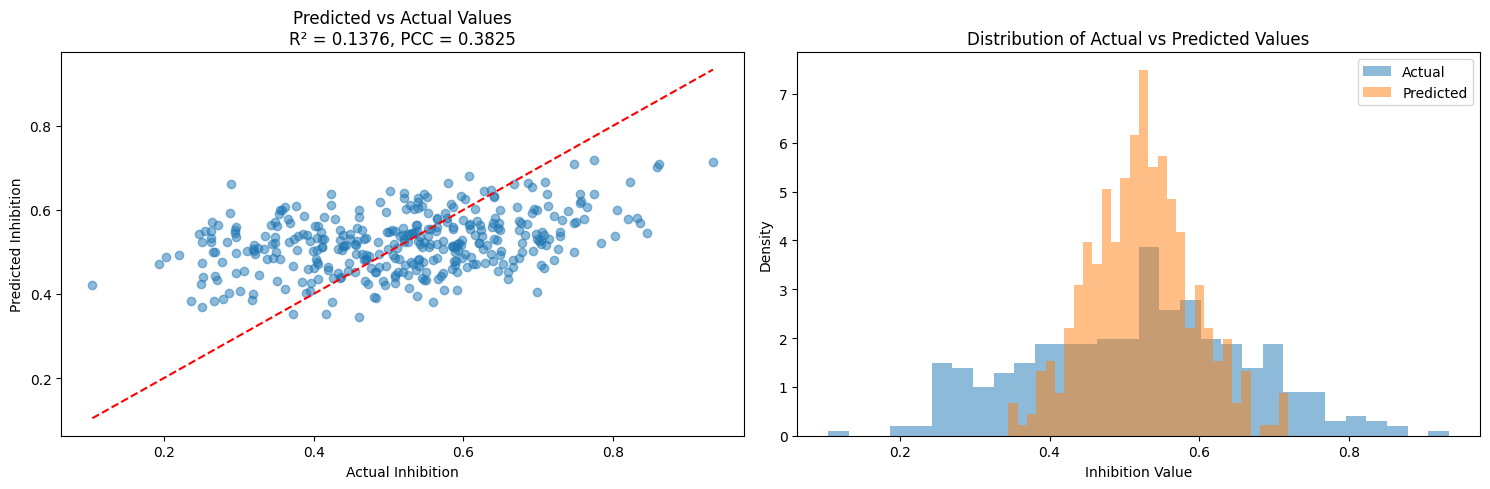

In [19]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load best model for testing
checkpoint = torch.load('best_model_rna_fm.pt')
model.load_state_dict(checkpoint['model_state_dict'])

# Test set evaluation
model.eval()
test_loss = 0
test_predictions = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        sirna_inputs = {k: v.to(device) for k, v in batch['sirna_inputs'].items()}
        mrna_inputs = {k: v.to(device) for k, v in batch['mrna_inputs'].items()}
        numerical_features = batch['numerical_features'].to(device)
        siRNA_features_array = batch['siRNA_features_array'].to(device)  # Add RNA-FM features
        labels = batch['labels'].to(device)
        
        # Include siRNA_features_array in model forward pass
        outputs = model(sirna_inputs, mrna_inputs, numerical_features, siRNA_features_array)
        test_loss += loss_fn(outputs.squeeze(), labels).item()
        
        # Store predictions and labels
        test_predictions.extend(outputs.squeeze().cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate metrics
avg_test_loss = test_loss / len(test_loader)
test_r2 = r2_score(test_labels, test_predictions)
test_pcc, _ = pearsonr(test_labels, test_predictions)

# Print results
print(f'\nTest Results:')
print(f'Average test loss: {avg_test_loss:.4f}')
print(f'Test R² score: {test_r2:.4f}')
print(f'Test PCC score: {test_pcc:.4f}')

# Create visualization plots
plt.figure(figsize=(15, 5))

# Scatter plot of predicted vs actual values
plt.subplot(1, 2, 1)
plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')  # Perfect prediction line
plt.xlabel('Actual Inhibition')
plt.ylabel('Predicted Inhibition')
plt.title(f'Predicted vs Actual Values\nR² = {test_r2:.4f}, PCC = {test_pcc:.4f}')

# Distribution plot
plt.subplot(1, 2, 2)
plt.hist(test_labels, bins=30, alpha=0.5, label='Actual', density=True)
plt.hist(test_predictions, bins=30, alpha=0.5, label='Predicted', density=True)
plt.xlabel('Inhibition Value')
plt.ylabel('Density')
plt.title('Distribution of Actual vs Predicted Values')
plt.legend()

plt.tight_layout()
plt.show()